In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import os
os.chdir('/content/drive/MyDrive/GL-GenAI/Week14-AdvancedRag')
os.listdir()

['config2_emb_tested-2.json',
 'requirements.txt',
 'Week_14_GANLP_LVC_Handson_03_17_25.ipynb',
 'xps-13-9340-owners-manual-en-us.pdf',
 'dellxps_images',
 'requirements_W14.txt',
 'config_GANLP.json',
 'config2_emb_tested.json',
 'SM-Week_14_GANLP_LVC_Handson_03_17_25.ipynb',
 'SM-Week_14_RAG.ipynb',
 'ResearchAssistant']

In [ ]:
# %%writefile requirements_W14.txt
# openai==1.55.3
# langchain==0.2.7
# langchain-community==0.2.7
# langchain-huggingface==0.0.3
# langchain-experimental==0.0.62
# langchain-openai==0.1.14
# chromadb==0.5.3
# sentence-transformers==3.0.1
# python-dotenv==1.0.1
# lark==1.1.9
# llama-index-core
# llama-parse==0.5.11
# llama-index-readers-file
# llama-index-llms-langchain

In [ ]:
%%writefile requirements_W14.txt
openai
langchain-community
langchain-huggingface
langchain-experimental
langchain-openai
langchain_chroma
sentence-transformers
python-dotenv
lark
llama-index-core
llama-parse
llama-index-readers-file
llama-index-llms-langchain

#numpy<2.0.0
transformers

Overwriting requirements_W14.txt


In [ ]:
!pip install -q -r requirements_W14.txt

In [ ]:
%%writefile config_GANLP.json
{
"API_KEY": "",
"OPENAI_API_BASE": ""
}

Overwriting config_GANLP.json


In [ ]:
%%writefile config2_emb_tested.json
{"EMB_MODEL_KEY": "",
 "EMB_DEPLOYMENT": "",
 "LLAMA_KEY": "",
 "claude_api": ""
}

Overwriting config2_emb_tested.json


- **CharacterTextSplitter** (from langchain.text_splitter)
  - Splits large text documents into smaller chunks based on a fixed character size.
  - Commonly used for chunking text before embedding it for retrieval or processing.

-  **RecursiveCharacterTextSplitter** (from langchain.text_splitter)
- A more advanced text splitter that recursively splits documents at different granularities (e.g., paragraphs, sentences) until a desired chunk size is reached.
- Prevents breaking content in the middle of meaningful segments  

- **SemanticChunker** (from langchain_experimental.text_splitter)
- Uses embeddings to chunk text based on meaning rather than just fixed character lengths.
- Creates more coherent and contextually relevant chunks.

- **OpenAIEmbeddings** (from langchain.embeddings and langchain_openai)
- Converts text into vector embeddings using OpenAI’s embedding models (e.g., text-embedding-ada-002).
- Used in vector databases for similarity search

- **LLMChainExtractor** (from langchain.retrievers.document_compressors)
- Extracts the most relevant content from a document using an LLM.
- Used for document compression in retrieval tasks.

-  **ContextualCompressionRetriever** (from langchain.retrievers)
- Compresses retrieved documents dynamically before returning them to the LLM.
- Uses extractors like LLMChainExtractor or CrossEncoderReranker.

- **CrossEncoderReranker** (from langchain.retrievers.document_compressors)
- Uses a cross-encoder model to rank retrieved documents for relevance.
- Improves retrieval accuracy by reranking search results.

- **HuggingFaceCrossEncode** (from langchain_community.cross_encoders)
- Provides cross-encoder models from Hugging Face for reranking retrieved documents.
- Used with CrossEncoderReranker.

**LlamaParse**  (from llama_parse)
- A powerful PDF parser that extracts structured text from documents.
- Handles tables, images, and layout preservation better than standard PDF parsers.

**Settings and SimpleDirectoryReader** (from llama_index.core)
- Settings: Configures LlamaIndex behavior.
- SimpleDirectoryReader: Reads multiple documents from a directory.

**Document** (from langchain_core.documents)
- Represents a single document for retrieval, embedding, or processing.

**Chroma** (from langchain_community.vectorstores)
- A vector database for storing embeddings and performing similarity search.
- Used in RAG (Retrieval-Augmented Generation) workflows.

**AttributeInfo** (from langchain.chains.query_constructor.base)
- Defines metadata attributes for self-query retrieval.
- Helps LLMs understand what fields are available in a vector database.


**SelfQueryRetriever** (from langchain.retrievers.self_query.base)
- Allows LLMs to generate queries dynamically based on user input.
- Improves search efficiency in vector databases.



**References:**

- **Embedding models:** https://python.langchain.com/v0.1/docs/integrations/text_embedding/

- **Data Loaders from langchain:** https://python.langchain.com/docs/integrations/document_loaders/


In [ ]:

# !pip install -q langchain_chroma

In [ ]:
#!pip freeze

In [ ]:
import os
import chromadb
from langchain_chroma import Chroma # import the Chroma class.
import requests

from dotenv import load_dotenv
from openai import OpenAI
from typing import Dict, Tuple, List
from langchain.text_splitter import (
    CharacterTextSplitter,
    RecursiveCharacterTextSplitter
)
from langchain_experimental.text_splitter import SemanticChunker
from langchain_openai import ChatOpenAI
from langchain.embeddings import OpenAIEmbeddings
from langchain_openai import OpenAIEmbeddings

from langchain.retrievers.document_compressors import LLMChainExtractor
from langchain.retrievers import ContextualCompressionRetriever
from langchain.retrievers.document_compressors import CrossEncoderReranker
from langchain_community.cross_encoders import HuggingFaceCrossEncoder
from llama_parse import LlamaParse
from llama_index.core import Settings, SimpleDirectoryReader
from langchain_core.documents import Document
from langchain_community.vectorstores import Chroma
from langchain.chains.query_constructor.base import AttributeInfo
from langchain.retrievers.self_query.base import SelfQueryRetriever

from google.colab import userdata

###**<font color=blue> Upload the config file in colab</font>**

Step 1: First, click on the icon highlighted in red.

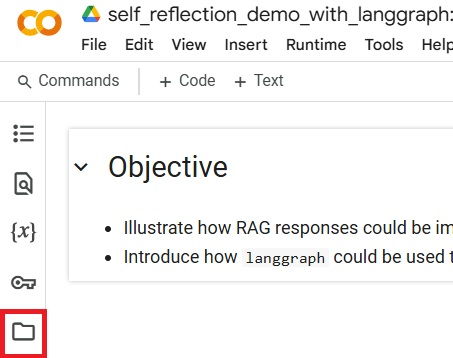

Step 2: Click on the next icon highlighted in red.

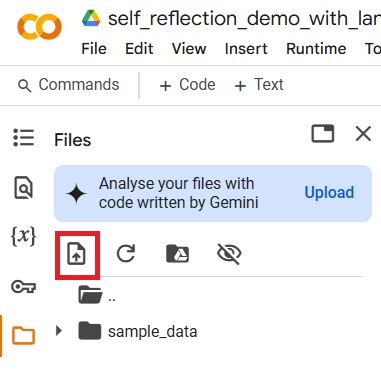

Step 3: Select config.json from the Downloads and click on open highlighted in red box.

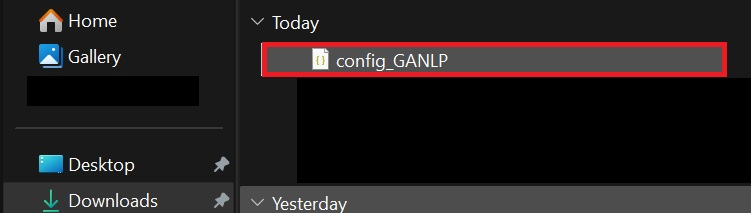

Step 4: A warning message will appear—click OK to proceed.

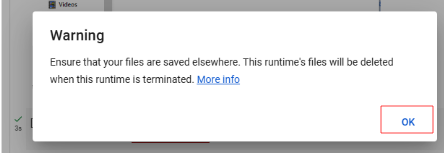

In [ ]:
import json

def read_config(config_file):
  """Reads a JSON config file and returns a dictionary."""
  with open(config_file, 'r') as f:
    return json.load(f)

config = read_config("config_GANLP.json")  #Copy and paste the path of the config file uploaded in Colab
config2 = read_config("config2_emb_tested.json")
api_key = config.get("API_KEY")
endpoint = config.get("OPENAI_API_BASE")
llamaparse_api_key = config2.get("LLAMA_KEY")

**chromadb.utils.embedding_functions.OpenAIEmbeddingFunction**

- This initializes an embedding function for ChromaDB, which is used inside ChromaDB’s vector store.
- It ensures that when documents are added to ChromaDB, they are converted into embeddings using OpenAI’s text-embedding-ada-002 before storage.
- It is directly tied to ChromaDB and cannot be used elsewhere.


In [ ]:
embedding_function = chromadb.utils.embedding_functions.OpenAIEmbeddingFunction(
    api_base=endpoint,
    api_key=api_key,
    model_name='text-embedding-ada-002'
)

In [ ]:
# Initialize OpenAI Embeddings correctly
embedding_model = OpenAIEmbeddings(
    openai_api_base=endpoint,
    openai_api_key=api_key,
    model="text-embedding-ada-002"
)

In [ ]:
from langchain_openai import ChatOpenAI

llm = ChatOpenAI(
    openai_api_base=endpoint,
    openai_api_key=api_key,
    model="gpt-4o-mini",
    streaming=False  # Explicitly disabling streaming
)

# Parsing

**Understanding nest_asyncio**

1. Import nest_asyncio
	•	This imports the nest_asyncio module, which is used to patch the asyncio event loop to allow nested event loops.

import nest_asyncio

2. Apply nest_asyncio
	•	This modifies the default event loop policy so that multiple nested event loops can run within the same process without encountering the error:

RuntimeError: This event loop is already running

nest_asyncio.apply()

Why is this needed?
- In Jupyter Notebooks, running asyncio code (such as calling await within an existing event loop) often results in errors because Jupyter itself runs an event loop in the background.
- nest_asyncio.apply() allows you to re-enter an already running event loop instead of creating a new one, making it possible to run async functions inside Jupyter cells.

Example Use Case

Without nest_asyncio, running an async function inside Jupyter might cause:

import asyncio

async def hello():
    print("Hello, async world!")

asyncio.run(hello())  # This might throw an error in Jupyter

In [ ]:
import nest_asyncio; nest_asyncio.apply()

In [ ]:
from dotenv import load_dotenv

In [ ]:
# Set environment variable to avoid tokenizer warnings
os.environ["TOKENIZERS_PARALLELISM"] = "false"

# Force reload of environment variables
load_dotenv(override=True)

False

Upload the PDF file to Colab

In [ ]:
pdf_file_path = 'xps-13-9340-owners-manual-en-us.pdf'

**LlamaParse does not run locally—it uses cloud resources to process documents.**

- The PDF file is uploaded to LlamaParse’s API.
- The text extraction happens on LlamaParse’s cloud servers.
- **The extracted text is then returned in the requested format (markdown, text, or json).**

**Why Does It Use Cloud Resources?**
- Better Parsing: LlamaParse handles complex layouts, tables, and images better than local parsers.
- Faster Processing: It can leverage distributed computing for large documents.
- Avoids Local Limitations: No need to install heavy dependencies like pdfplumber or PyMuPDF.

**Does It Support Local Processing?**

**No, LlamaParse is fully cloud-based,** and **you must have an API key** to use it.

**Alternative for Local Parsing**

If you need a local alternative, you can use:
- PyMuPDF (fitz): For simple text extraction.
- pdfplumber: For table extraction.
- unstructured: For structured document processing.


**LlamaParse: An Advanced PDF Parsing Tool**

- **LlamaParse is part of LlamaIndex**, a powerful framework designed to work with unstructured data (such as PDFs, Word documents, and other text-based files) for large language models (LLMs).
- It provides a way to efficiently extract and structure text from PDFs while handling complex document layouts.

1. **result_type="markdown"**

	•	Specifies the format of the extracted text.
	•	"markdown" means the extracted content will be formatted in Markdown, which preserves structure (e.g., headings, lists, and formatting).

2. **skip_diagonal_text=True**

	•	Helps avoid text that appears diagonal in PDFs (common in watermarks, rotated text, or certain scanned documents).
	•	Prevents extracting unwanted non-linear text.

3. **fast_mode=False**

	•	If True, LlamaParse prioritizes speed over accuracy.
	•	If False, it ensures more thorough parsing, even if it’s slower.

4. **num_workers=9**

	•	Controls parallel processing by using 9 worker threads to process documents faster.
	•	Higher values improve performance on large documents but consume more CPU resources.

5. **check_interval=10**

	•	Defines how often (in seconds) the parser checks the API for processing status updates when handling large documents asynchronously.

6. **api_key=llamaparse_api_key**

	•	Requires an API key to authenticate with LlamaParse’s cloud-based document parsing service.

In [ ]:
parser = LlamaParse(
    result_type="markdown",
    skip_diagonal_text=True,
    fast_mode=False,
    num_workers=9,
    check_interval=10,
    api_key=llamaparse_api_key
)

In [ ]:
json_objs = parser.get_json_result(pdf_file_path)

Started parsing the file under job_id 7679ce90-a10c-4653-9faa-cf078eea8162


In [ ]:
json_list = json_objs[0]["pages"]

In [ ]:
json_list

- LlamaParse doesn’t just extract text; it also detects embedded images in PDFs.
- The images are extracted separately, and their locations are referenced in the JSON.
- Using parser.get_images(), you can download those images for further processing.

- 👉 **LlamaParse does NOT do OCR** (text extraction from images) or object recognition.
- **LlamaParse extracts tables from PDFs** and provides them in a structured format.

In [ ]:
image_dicts = parser.get_images(
    json_objs,
    download_path="dellxps_images"
)

> Images for page 1: []
> Images for page 2: []
> Images for page 3: []
> Images for page 4: []
> Images for page 5: []
> Images for page 6: [{'name': 'img_p5_1.png', 'height': 312, 'width': 1710, 'x': 92.43780000000001, 'y': 192.59763500000003, 'original_width': 1710, 'original_height': 312}, {'name': 'img_p5_2.png', 'height': 312, 'width': 1710, 'x': 92.43780000000001, 'y': 464.544075, 'original_width': 1710, 'original_height': 312}]
> Images for page 7: [{'name': 'img_p6_1.png', 'height': 1170, 'width': 1710, 'x': 36.8504, 'y': 101.43543600000004, 'original_width': 1710, 'original_height': 1170, 'ocr': [{'x': 22, 'y': 192, 'w': 30, 'h': 36, 'confidence': '0.9999969005608733', 'text': '5'}, {'x': 241, 'y': 229, 'w': 26, 'h': 14, 'confidence': '0.990835059286968', 'text': 'esc'}, {'x': 1129, 'y': 229, 'w': 24, 'h': 14, 'confidence': '0.43869986060696464', 'text': 'F1o'}, {'x': 1299, 'y': 229, 'w': 22, 'h': 14, 'confidence': '0.45599057426599643', 'text': 'F12'}, {'x': 1417, 'y': 227, 

In [ ]:
page_texts, tables = {}, {}

In [ ]:
for json_item in json_list:

    page_texts[json_item['page']] = ''

    if json_item['md']:
        page_texts[json_item['page']] = json_item['md']

    tables[json_item['page']] = []

    for component in json_item['items']:
        if component['type'] == 'table':
            tables[json_item['page']] = component['rows']

In [ ]:
# Generate Table Descriptions

## Look at the table on a specific page
print(tables[2])


[]


In [ ]:
table_describer_system_message = """
You are tasked to explain operating manual documents for Dell laptops.
You are required to generate a detailed description of rows of tables presented to you as the input.
Be detailed in your description and cover all the rows of the table presented to you.
The input will be presented as a list of rows.
Remember to describe ALL the rows in the input table in great detail.
"""


In [ ]:
## Generating the description of a sample table

table_description_prompt = [
    {'role': 'system', 'content': table_describer_system_message},
    {'role': 'user', 'content': str(tables[2])}
]


In [ ]:
try:
    response = llm.chat.completions.create(
        model=llm,
        messages=table_description_prompt,
        temperature=0
    )
    description = response.choices[0].message.content
except Exception as e:
    description = ''

In [ ]:
print(description)

In [ ]:
# Generate Image Descriptions

## Look at an image on a specific image
image_dicts[0]

{'name': 'img_p5_1.png',
 'height': 312,
 'width': 1710,
 'x': 92.43780000000001,
 'y': 192.59763500000003,
 'original_width': 1710,
 'original_height': 312,
 'path': 'dellxps_images/7679ce90-a10c-4653-9faa-cf078eea8162-img_p5_1.png',
 'job_id': '7679ce90-a10c-4653-9faa-cf078eea8162',
 'original_file_path': 'xps-13-9340-owners-manual-en-us.pdf',
 'page_number': 6}

In [ ]:
hf_api_key = userdata.get('HF_TOKEN')
lmm = "Salesforce/blip-image-captioning-large"

In [ ]:
sample_image_path = image_dicts[0]['path']

## Generating the description of a sample image

hf_api_url = "https://api-inference.huggingface.co/models/" + lmm

headers = {"Authorization": f"Bearer {hf_api_key}"}

try:
    with open(sample_image_path, "rb") as f:
        data = f.read()

    response = requests.post(
        hf_api_url,
        headers=headers,
        data=data
    )

    caption = response.json()
except Exception as e:
    print(e)
    caption = ''

print(caption)

[{'generated_text': 'a close up of a computer with a keyboard and a mouse'}]


# Chunking

In [ ]:
text = """
We design, develop, manufacture, sell and lease high-performance fully electric vehicles and energy generation and storage systems, and offer services related to our products. We generally sell our products directly to customers, and continue to grow our customer-facing infrastructure through a global network of vehicle showrooms and service centers, Mobile Service, body shops, Supercharger stations and Destination Chargers to accelerate the widespread adoption of our products. We emphasize performance, attractive styling and the safety of our users and workforce in the design and manufacture of our products and are continuing to develop full self-driving technology for improved safety. We also strive to lower the cost of ownership for our customers through continuous efforts to reduce manufacturing costs and by offering financial and other services tailored to our products.

Our core vehicle technology competencies include powertrain engineering and manufacturing and our ability to design vehicles that utilize the unique advantages of an electric powertrain. We have designed our proprietary powertrain systems to be adaptable, efficient, reliable and cost-effective while withstanding the rigors of an automotive environment. We offer dual motor powertrain vehicles, which use two electric motors to maximize traction and performance in an all-wheel drive configuration, as well as vehicle powertrain technology featuring three electric motors for further increased performance in certain versions of Model S and Model X, Cybertruck and the Tesla Semi.

We have a growing global network of Tesla Superchargers, which are our industrial-grade, high-speed vehicle chargers. Where possible, we co- locate Superchargers with our solar and energy storage systems to reduce costs and promote renewable power. Supercharger stations are typically placed along well-traveled routes and in and around dense city centers to allow vehicle owners the ability to enjoy quick, reliable charging along an extensive network with convenient stops. Use of the Supercharger network either requires payment of a fee or is free under certain sales programs. In November 2021, we began to offer Supercharger access to non-Tesla vehicles in certain locations in support of our mission to accelerate the world’s transition to sustainable energy, and in November 2022, we opened up our previously proprietary charging connector as the North American Charging Standard (NACS). This enables all electric vehicles and charging stations to interoperate — which makes charging easier and more efficient for everyone and advances our mission to accelerate the world’s transition to sustainable energy. Following this, a number of major automotive companies announced their adoption of NACS, with their access to the Supercharger network beginning in phases in 2024 and their production of NACS vehicles beginning no later than 2025. We also engaged SAE International to govern NACS as an industry standard, now named J3400. We continue to monitor and increase our network of Tesla Superchargers in anticipation of future demand.
"""

In [ ]:
# Character-level chunking

character_text_splitter = CharacterTextSplitter.from_tiktoken_encoder(
    encoding_name='cl100k_base',
    chunk_size=512,
    chunk_overlap=16,
    separator=''
)

character_documents = character_text_splitter.create_documents([text])

In [ ]:
character_documents[0].page_content

'We design, develop, manufacture, sell and lease high-performance fully electric vehicles and energy generation and storage systems, and offer services related to our products. We generally sell our products directly to customers, and continue to grow our customer-facing infrastructure through a global network of vehicle showrooms and service centers, Mobile Service, body shops, Supercharger stations and Destination Chargers to accelerate the widespread adoption of our products. We emphasize performance, at'

In [ ]:
character_documents[1].page_content

'performance, attractive styling and the safety of our users and workforce in the design and manufacture of our products and are continuing to develop full self-driving technology for improved safety. We also strive to lower the cost of ownership for our customers through continuous efforts to reduce manufacturing costs and by offering financial and other services tailored to our products.\n\nOur core vehicle technology competencies include powertrain engineering and manufacturing and our ability to design ve'

In [ ]:
# Recursive character-level chunking

recursive_text_splitter = RecursiveCharacterTextSplitter.from_tiktoken_encoder(
    encoding_name='cl100k_base',
    chunk_size=512,
    chunk_overlap=16,
    is_separator_regex=False
)

recursive_character_documents = recursive_text_splitter.create_documents([text])

In [ ]:

recursive_character_documents[0].page_content

'We design, develop, manufacture, sell and lease high-performance fully electric vehicles and energy generation and storage systems, and offer services related to our products. We generally sell our products directly to customers, and continue to grow our customer-facing infrastructure through a global network of vehicle showrooms and service centers, Mobile Service, body shops, Supercharger stations and Destination Chargers to accelerate the widespread adoption of our products. We emphasize performance, attractive styling and the safety of our users and workforce in the design and manufacture of our products and are continuing to develop full self-driving technology for improved safety. We also strive to lower the cost of ownership for our customers through continuous efforts to reduce manufacturing costs and by offering financial and other services tailored to our products.\n\nOur core vehicle technology competencies include powertrain engineering and manufacturing and our ability to

In [ ]:
recursive_character_documents[1].page_content

'We have a growing global network of Tesla Superchargers, which are our industrial-grade, high-speed vehicle chargers. Where possible, we co- locate Superchargers with our solar and energy storage systems to reduce costs and promote renewable power. Supercharger stations are typically placed along well-traveled routes and in and around dense city centers to allow vehicle owners the ability to enjoy quick, reliable charging along an extensive network with convenient stops. Use of the Supercharger network either requires payment of a fee or is free under certain sales programs. In November 2021, we began to offer Supercharger access to non-Tesla vehicles in certain locations in support of our mission to accelerate the world’s transition to sustainable energy, and in November 2022, we opened up our previously proprietary charging connector as the North American Charging Standard (NACS). This enables all electric vehicles and charging stations to interoperate — which makes charging easier 

## 🔹 **What is Semantic Chunking?**
- semantic chunking is a more context-aware way of splitting text compared to character-based chunking methods like RecursiveCharacterTextSplitter.

🔹 **How Does It Work?**

	1.	Embeddings Model (embedding_model):
	•	The text is converted into embeddings (numerical representations of meaning).
	•	This helps detect where logical breaks should occur.
	2.	Breakpoint Threshold (breakpoint_threshold_type='gradient'):
	•	Determines where to split text based on semantic shifts.
	•	The ‘gradient’ method detects sharp meaning changes (e.g., topic transitions) and places chunk breakpoints accordingly.
	3.	Chunking (create_documents([text])):
	•	The function splits the text into meaningful document chunks.
	•	Each chunk contains logically related sentences or paragraphs.

⸻

🔹 **Why Does SemanticChunker Not Have chunk_size and chunk_overlap?**

	•	No chunk_size → Because chunks are determined dynamically based on meaning, rather than a fixed number of characters/tokens.
	•	No chunk_overlap → Since the method keeps sentences together, overlaps are not explicitly needed (but a retriever can still handle sliding window approaches if necessary).

 ```python
 from langchain_experimental.text_splitter import SemanticChunker
# Semantic chunking

semantic_text_splitter = SemanticChunker(
    embedding_model,
    breakpoint_threshold_type='gradient'
)

semantic_documents = semantic_text_splitter.create_documents([text])
```



In [ ]:
from langchain_experimental.text_splitter import SemanticChunker
# Semantic chunking

semantic_text_splitter = SemanticChunker(
    embedding_model,
    breakpoint_threshold_type='gradient'
)

semantic_documents = semantic_text_splitter.create_documents([text])

In [ ]:
semantic_documents[0].page_content

'\nWe design, develop, manufacture, sell and lease high-performance fully electric vehicles and energy generation and storage systems, and offer services related to our products. We generally sell our products directly to customers, and continue to grow our customer-facing infrastructure through a global network of vehicle showrooms and service centers, Mobile Service, body shops, Supercharger stations and Destination Chargers to accelerate the widespread adoption of our products. We emphasize performance, attractive styling and the safety of our users and workforce in the design and manufacture of our products and are continuing to develop full self-driving technology for improved safety. We also strive to lower the cost of ownership for our customers through continuous efforts to reduce manufacturing costs and by offering financial and other services tailored to our products. Our core vehicle technology competencies include powertrain engineering and manufacturing and our ability to 

In [ ]:
semantic_documents[1].page_content

''

# Retrieval

In [ ]:
chromadb_client = chromadb.EphemeralClient()

In [ ]:
collection = chromadb_client.get_or_create_collection(
    name='full_document_chunks',
    metadata={"hnsw:space": "cosine"},
    embedding_function=embedding_function
)

In [ ]:
documents = [
    Document(
        id=1,
        page_content="We design, develop, manufacture, sell and lease high-performance fully electric vehicles and energy generation and storage systems, and offer services related to our products. We generally sell our products directly to customers, and continue to grow our customer-facing infrastructure through a global network of vehicle showrooms and service centers, Mobile Service, body shops, Supercharger stations and Destination Chargers to accelerate the widespread adoption of our products. We emphasize performance, attractive styling and the safety of our users and workforce in the design and manufacture of our products and are continuing to develop full self-driving technology for improved safety. We also strive to lower the cost of ownership for our customers through continuous efforts to reduce manufacturing costs and by offering financial and other services tailored to our products.",
        metadata={"year": 2023, "section": "business"}
    ),
    Document(
        id=2,
        page_content="We have previously experienced and may in the future experience launch and production ramp delays for new products and features. For example, we encountered unanticipated supplier issues that led to delays during the initial ramp of our first Model X and experienced challenges with a supplier and with ramping full automation for certain of our initial Model 3 manufacturing processes. In addition, we may introduce in the future new or unique manufacturing processes and design features for our products. As we expand our vehicle offerings and global footprint, there is no guarantee that we will be able to successfully and timely introduce and scale such processes or features.",
        metadata={"year": 2023, "section": "risk_factors"}
    ),
    Document(
        id=3,
        page_content="We recognize the importance of assessing, identifying, and managing material risks associated with cybersecurity threats, as such term is defined in Item 106(a) of Regulation S-K. These risks include, among other things: operational risks, intellectual property theft, fraud, extortion, harm to employees or customers and violation of data privacy or security laws. Identifying and assessing cybersecurity risk is integrated into our overall risk management systems and processes. Cybersecurity risks related to our business, technical operations, privacy and compliance issues are identified and addressed through a multi-faceted approach including third party assessments, internal IT Audit, IT security, governance, risk and compliance reviews. To defend, detect and respond to cybersecurity incidents, we, among other things: conduct proactive privacy and cybersecurity reviews of systems and applications, audit applicable data policies, perform penetration testing using external third-party tools and techniques to test security controls, operate a bug bounty program to encourage proactive vulnerability reporting, conduct employee training, monitor emerging laws and regulations related to data protection and information security (including our consumer products) and implement appropriate changes.",
        metadata={"year": 2023, "section": "cyber_security"}
    ),
    Document(
        id=4,
        page_content="The automotive segment includes the design, development, manufacturing, sales and leasing of high-performance fully electric vehicles as well as sales of automotive regulatory credits. Additionally, the automotive segment also includes services and other, which includes non-warranty after- sales vehicle services and parts, sales of used vehicles, retail merchandise, paid Supercharging and vehicle insurance revenue. The energy generation and storage segment includes the design, manufacture, installation, sales and leasing of solar energy generation and energy storage products and related services and sales of solar energy systems incentives.",
        metadata={"year": 2022, "section": "business"}
    ),
    Document(
        id=5,
        page_content="Since the first quarter of 2020, there has been a worldwide impact from the COVID-19 pandemic. Government regulations and shifting social behaviors have, at times, limited or closed non-essential transportation, government functions, business activities and person-to-person interactions. Global trade conditions and consumer trends that originated during the pandemic continue to persist and may also have long-lasting adverse impact on us and our industries independently of the progress of the pandemic.",
        metadata={"year": 2022, "section": "risk_factors"}
    ),
    Document(
        id=6,
        page_content="The German Umweltbundesamt issued our subsidiary in Germany a notice and fine in the amount of 12 million euro alleging its non-compliance under applicable laws relating to market participation notifications and take-back obligations with respect to end-of-life battery products required thereunder. In response to Tesla’s objection, the German Umweltbundesamt issued Tesla a revised fine notice dated April 29, 2021 in which it reduced the original fine amount to 1.45 million euro. This is primarily relating to administrative requirements, but Tesla has continued to take back battery packs, and filed a new objection in June 2021. A hearing took place on November 24, 2022, and the parties reached a settlement which resulted in a further reduction of the fine to 600,000 euro. Both parties have waived their right to appeal.",
        metadata={"year": 2022, "section": "legal_proceedings"}
    )
]


In [ ]:
collection.add(
    ids=[d.id for d in documents],
    documents=[d.page_content for d in documents],
    metadatas=[d.metadata for d in documents]
)

In [ ]:
# Structured Retrieval

# To be able to filter by metadata, the retrieval needs access to metadata descriptions

vectorstore = Chroma(
    client=chromadb_client,
    collection_name="full_document_chunks",
    embedding_function=embedding_model
)


In [ ]:
metadata_field_info = [
    AttributeInfo(
        name="year",
        description="The year for which the 10-K statement was prepared",
        type="integer"
    ),
    AttributeInfo(
        name="section",
        description="Section within the 10-k statement that the document belongs to",
        type="string"
    )
]

In [ ]:
document_content_description = "Specific information mentioned in the 10-k statement"

In [ ]:
structured_retriever = SelfQueryRetriever.from_llm(
    llm,
    vectorstore,
    document_content_description,
    metadata_field_info
)

In [ ]:
structured_retriever.invoke("Any specific fines levied on the company in 2022?")


[Document(metadata={'section': 'legal_proceedings', 'year': 2022}, page_content='The German Umweltbundesamt issued our subsidiary in Germany a notice and fine in the amount of 12 million euro alleging its non-compliance under applicable laws relating to market participation notifications and take-back obligations with respect to end-of-life battery products required thereunder. In response to Tesla’s objection, the German Umweltbundesamt issued Tesla a revised fine notice dated April 29, 2021 in which it reduced the original fine amount to 1.45 million euro. This is primarily relating to administrative requirements, but Tesla has continued to take back battery packs, and filed a new objection in June 2021. A hearing took place on November 24, 2022, and the parties reached a settlement which resulted in a further reduction of the fine to 600,000 euro. Both parties have waived their right to appeal.'),
 Document(metadata={'section': 'risk_factors', 'year': 2022}, page_content='Since the 

In [ ]:
# Hypothetical Questions

hypothetical_questions_prompt = """
Generate a list of exactly 3 hypothetical questions that the below document could be used to answer:
{doc}
Generate only a list of questions. Do not mention anything before or after the list.
"""


In [ ]:

hypothetical_question_documents = []


In [ ]:

for document in documents:

    try:
        response = llm.invoke(hypothetical_questions_prompt.format(doc=document))

        questions = response.content
    except Exception as e:
        print(e)
        questions = ""

    questions_metadata = {
        'parent_chunk_id': document.id,
        'parent_collection': 'full_document_chunks'
    }

    hypothetical_question_documents.append(
        Document(
            id=document.id,
            page_content=questions,
            metadata=questions_metadata
        )
    )


In [ ]:
collection = chromadb_client.get_or_create_collection(
    name='hypothetical_questions',
    metadata={"hnsw:space": "cosine"},
    embedding_function=embedding_function
)

In [ ]:
collection.add(
    ids=[d.id for d in hypothetical_question_documents],
    documents=[d.page_content for d in hypothetical_question_documents],
    metadatas=[d.metadata for d in hypothetical_question_documents]
)

In [ ]:
# Retriever over questions

vectorstore = Chroma(
    client=chromadb_client,
    collection_name="hypothetical_questions",
    embedding_function=embedding_model
)

In [ ]:
retriever = vectorstore.as_retriever(
    search_type="similarity",
    search_kwargs={'k': 5}
)


In [ ]:
hypothetical_questions_retrieved = retriever.invoke("Any specific fines levied on the company in 2022?")

In [ ]:
hypothetical_questions_retrieved[0]

Document(metadata={'parent_chunk_id': '6', 'parent_collection': 'full_document_chunks'}, page_content='1. What were the reasons for the initial fine imposed on Tesla by the German Umweltbundesamt regarding end-of-life battery products?\n2. How did Tesla respond to the initial fine, and what changes were made to the fine amount throughout the legal proceedings?\n3. What was the outcome of the settlement reached between Tesla and the German Umweltbundesamt in November 2022?')

In [ ]:
# Query Expansion

query_expansion_prompt = """
You are an financial domain expert assisting in answering questions related to 10-k reports.
Perform query expansion on the question received. If there are multiple common ways of phrasing a user question \
or common synonyms for key words in the question, make sure to return multiple versions \
of the query with the different phrasings.

If there are acronyms or words you are not familiar with, do not try to rephrase them.

Return at least 3 versions of the question as a list.
Generate only a list of questions. Do not mention anything before or after the list.

Question:
{question}
"""

In [ ]:
user_input = "Any specific fines levied on the company in 2022?"


In [ ]:
query_expansions = llm.invoke(query_expansion_prompt.format(question=user_input))

In [ ]:
query_expansions_list = query_expansions.content.split("\n")


In [ ]:
query_expansions_list

['1. Were there any particular fines imposed on the company in 2022?',
 '2. Did the company incur any specific penalties in 2022?',
 '3. What fines were assessed against the company in 2022?']

In [ ]:
vectorstore = Chroma(
    client=chromadb_client,
    collection_name="full_document_chunks",
    embedding_function=embedding_model
)

In [ ]:
retriever = vectorstore.as_retriever(
    search_type="similarity",
    search_kwargs={
        'k': 5
    }
)


In [ ]:
context_list = []

In [ ]:
for query in query_expansions_list:
    context_list.extend([d.page_content for d in retriever.invoke(query)])
    break


In [ ]:
context_list

['The German Umweltbundesamt issued our subsidiary in Germany a notice and fine in the amount of 12 million euro alleging its non-compliance under applicable laws relating to market participation notifications and take-back obligations with respect to end-of-life battery products required thereunder. In response to Tesla’s objection, the German Umweltbundesamt issued Tesla a revised fine notice dated April 29, 2021 in which it reduced the original fine amount to 1.45 million euro. This is primarily relating to administrative requirements, but Tesla has continued to take back battery packs, and filed a new objection in June 2021. A hearing took place on November 24, 2022, and the parties reached a settlement which resulted in a further reduction of the fine to 600,000 euro. Both parties have waived their right to appeal.',
 'Since the first quarter of 2020, there has been a worldwide impact from the COVID-19 pandemic. Government regulations and shifting social behaviors have, at times, 

# Compressors

**LLMChainExtractor.from_llm(llm)** creates a compression model using a language model (LLM).
- It extracts only the most relevant parts of documents instead of returning the entire text.
- This is useful when dealing with long documents, ensuring that only key information is passed to the LLM.

- **it does not create a new LLM. Instead, it wraps an existing LLM (like gpt-4 or gpt-3.5) and configures it to act as an extractor that compresses retrieved documents.**

🔹 How Does It Work?

	1.	An existing LLM (e.g., GPT-4) is passed into LLMChainExtractor.
	2.	The LLM is prompted to find and return only the key information based on the user’s query.
	3.	It outputs a compressed document, removing unnecessary details.

**ContextualCompressionRetriever combines:**
- base_compressor: The LLM-powered extractor (LLMChainExtractor).
- base_retriever: The retriever that fetches documents based on user queries.
- Purpose: Instead of retrieving full documents, it retrieves and compresses the relevant parts before passing them to the LLM.

```python
compressed_docs = compression_retriever.invoke(user_input)
```

- User input (query) is passed to the retriever.
- The retriever fetches relevant documents from the vector database.
- The compressor extracts only the necessary portions.
- The result is a compressed list of documents containing only the most relevant content.

📌 Why Use Information Compression?

✅ Reduces token usage → Helps in LLMs with context length limits.

✅ Improves retrieval accuracy → Filters only the relevant parts of documents.

✅ Speeds up inference → LLMs process less data, reducing computation time.

In [ ]:
# Information compression

compressor = LLMChainExtractor.from_llm(llm)

In [ ]:
compression_retriever = ContextualCompressionRetriever(
    base_compressor=compressor, base_retriever=retriever
)

In [ ]:
compressed_docs = compression_retriever.invoke(user_input)

In [ ]:
for compressed_doc in compressed_docs:
    print(compressed_doc.page_content)

The German Umweltbundesamt issued our subsidiary in Germany a notice and fine in the amount of 12 million euro alleging its non-compliance under applicable laws relating to market participation notifications and take-back obligations with respect to end-of-life battery products required thereunder. In response to Tesla’s objection, the German Umweltbundesamt issued Tesla a revised fine notice dated April 29, 2021 in which it reduced the original fine amount to 1.45 million euro. A hearing took place on November 24, 2022, and the parties reached a settlement which resulted in a further reduction of the fine to 600,000 euro.


### Understanding Reranking in Document Retrieval

This code is implementing reranking to improve the quality of retrieved documents before they are passed to an LLM. It does so using a cross-encoder model from Hugging Face.


- This creates pairs of user queries and retrieved documents.
- Each pair consists of:
    - User input (query)
    - A retrieved document (doc_text)
    - The cross-encoder will assign a relevance score to each query-document pair.


- Loads a cross-encoder model **(ms-marco-MiniLM-L-6-v2)**.
- **Unlike bi-encoder retrievers (e.g., embeddings + vector search), a cross-encoder directly compares the user query with each document before ranking them.**  

- Assigns a relevance score to each query-document pair.
- Higher scores mean the document is more relevant to the query.

```python
reranker = CrossEncoderReranker(model=crossencoder, top_n=5)
```

- Wraps the crossencoder in CrossEncoderReranker.
- The top_n=5 parameter ensures that only the top 5 most relevant documents are kept.


**Apply the Reranker to the Original Retriever**
```python
reranker_retriever = ContextualCompressionRetriever(
    base_compressor=reranker, base_retriever=retriever
)
```

- Combines the reranker with the original retriever (retriever).
- nstead of returning documents in their original order, it reranks them based on relevance.

**Retrieve and Rerank Documents**
```python
reranked_docs = reranker_retriever.invoke(user_input)
```

- Fetches documents using the original retriever.
- Re-scores and re-ranks them using the cross-encoder.
- Returns only the most relevant documents.


**Check if the Order Changed After Reranking**

```python
for i in range(len(reranked_docs)):
    if reranked_docs[i].page_content == context_list[i]:
        continue
    else:
        print(f"Document at rank: {i} after reranking differs from the original order")

```
- Compares the reranked document order to the original order.
- If a document moves up or down in rank, it prints a message.        

## 🔷 Summary of the Code

| Step | Action |
|------|--------|
| 1️⃣ **Create query-document pairs** | Prepares the data for scoring. |
| 2️⃣ **Load cross-encoder model** | Uses `ms-marco-MiniLM-L-6-v2` to score documents. |
| 3️⃣ **Score documents** | Assigns a **relevance score** to each document. |
| 4️⃣ **Select top-ranked documents** | Filters out low-ranking documents (`top_n=5`). |
| 5️⃣ **Use reranking with retriever** | Improves relevance before passing to the LLM. |
| 6️⃣ **Retrieve and rerank documents** | Retrieves docs, re-ranks them, and returns the best ones. |
| 7️⃣ **Check if rankings changed** | Compares old and new rankings to confirm reranking worked. |

📌 Why Use Reranking?

✅ Improves retrieval accuracy → Ensures the most relevant documents are prioritized.

✅ Removes noise → Eliminates less relevant documents from retrieval.

✅ Enhances RAG pipelines → Helps LLMs get the right context, improving responses.



In [ ]:
# Reranking

context_query_pairs_for_scoring = [[user_input, doc_text] for doc_text in context_list]

In [ ]:
crossencoder = HuggingFaceCrossEncoder(model_name="cross-encoder/ms-marco-MiniLM-L-6-v2")

/usr/local/lib/python3.11/dist-packages/sentence_transformers/cross_encoder/CrossEncoder.py:11: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm, trange


config.json:   0%|          | 0.00/794 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/316 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

In [ ]:
crossencoder.score(context_query_pairs_for_scoring)

array([ -1.5920798, -10.410274 , -11.38096  , -11.157393 , -11.252782 ],
      dtype=float32)

In [ ]:
reranker = CrossEncoderReranker(model=crossencoder, top_n=5)

In [ ]:
reranker_retriever = ContextualCompressionRetriever(
    base_compressor=reranker, base_retriever=retriever
)

In [ ]:
reranked_docs = reranker_retriever.invoke(user_input)

In [ ]:
for i in range(len(reranked_docs)):
    if reranked_docs[i].page_content == context_list[i]:
        continue
    else:
        print(f"Document at rank: {i} after reranking differs from the original order")

Document at rank: 2 after reranking differs from the original order
Document at rank: 3 after reranking differs from the original order
Document at rank: 4 after reranking differs from the original order


# RAGAS

**RAGAS: Retrieval-Augmented Generation Assessment Score**

**RAGAS (Retrieval-Augmented Generation Assessment Score)** is a framework designed to evaluate the quality of RAG (Retrieval-Augmented Generation) pipelines.
- It helps assess how well retrieved documents contribute to generating accurate and contextually relevant responses.

🔹 **Why Do We Need RAGAS?**

In a RAG pipeline, an LLM generates answers based on retrieved documents. However, not all retrieved documents are useful—some may be irrelevant or misleading.

**RAGAS helps measure:**
✅ Relevance – Are the retrieved documents relevant to the query?

✅ Faithfulness – Does the generated response accurately reflect the retrieved information?

✅ Answer Correctness – Is the final output factually correct?

✅ Diversity – Are retrieved documents covering diverse, relevant perspectives?

🔹 **How Does RAGAS Work?**

**RAGAS scores a RAG pipeline by evaluating:**
1.	**Retrieval Quality** – How well does retrieval return useful information?
2.	**Generation Quality** – Does the LLM use the retrieved data effectively?
3.	**Overall Pipeline Performance** – How reliable is the entire RAG system?

It typically works by automating evaluation using metrics derived from LLM-based comparisons and human-aligned benchmarks.

## 🔷 Key Metrics in RAGAS

| **Metric**            | **What It Measures**  |
|----------------------|----------------------|
| **Context Precision** | How relevant retrieved documents are to the query. |
| **Faithfulness**      | Whether the generated answer stays true to retrieved docs (no hallucinations). |
| **Answer Correctness** | If the generated response is factually correct. |
| **Diversity**        | Whether retrieved documents come from multiple useful sources. |


🔹 **Example: Using RAGAS to Evaluate a RAG System**

```python
from ragas import evaluate_rag

score = evaluate_rag(
    query="What is deep learning?",
    retrieved_docs=[
        "Deep learning is a subset of machine learning that uses neural networks.",
        "Neural networks improve performance by learning from data."
    ],
    generated_response="Deep learning is a type of AI that uses neural networks for learning."
)

print(score)
```

🔹 Output:

```json
{
    "context_precision": 0.95,
    "faithfulness": 0.92,
    "answer_correctness": 0.98,
    "diversity": 0.80
}
```


🔹 **Why is RAGAS Important?**

✅ **Prevents Hallucinations** – Ensures the LLM is not making up facts.

✅ **Optimizes Retrieval** – Helps improve the document retriever in a RAG pipeline.

✅ **Improves Trustworthiness** – Ensures that responses are factually based on retrieved sources.

⸻

🔹 Summary
- RAGAS = A scoring system for RAG pipelines.
- Measures retrieval and generation quality.
- Evaluates context relevance, correctness, and faithfulness.
- Helps reduce hallucinations and improve response reliability.



In [ ]:
context = """
### Context:
In 2020, we recognized total revenues of $31.54 billion, representing an increase of $6.96 billion compared to the prior year. We continue to ramp production, build new manufacturing capacity and expand our operations to enable increased deliveries and deployments of our products and further revenue growth. In 2020, our net income attributable to common stockholders was $721 million, representing a favorable change of $1.58 billion compared to the prior year. In 2020, our operating margin was 6.3%, representing a favorable change of 6.6% compared to the prior year. We continue to focus on operational efficiencies, while we have seen an acceleration of non-cash stock-based compensation expense due to a rapid increase in our market capitalization and updates to our business outlook. We ended 2020 with $19.38 billion in cash and cash equivalents, representing an increase of $13.12 billion from the end of 2019. Our cash flows from operating activities during 2020 was $5.94 billion, compared to $2.41 billion during 2019, and capital expenditures amounted to $3.16 billion during 2020, compared to $1.33 billion during 2019. Sustained growth has allowed our business to generally fund itself, but we will continue a number of capital-intensive projects in upcoming periods. Management Opportunities, Challenges and Risks and 2021 Outlook Impact of COVID-19 Pandemic.2020 compared to 2019 Automotive sales revenue increased $6.23 billion, or 31%, in the year ended December 31, 2020 as compared to the year ended December 31, 2019, primarily due to an increase of 129,268 Model 3 and Model Y cash deliveries despite production limitations as a result of temporary suspension of production at the Fremont Factory and Gigafactory Nevada during the first half of 2020. We were able to increase deliveries year over year from production ramping at both Gigafactory Shanghai and the Fremont Factory. There was also an increase of $986 million from additional sales of regulatory credits to $1.58 billion in the year ended December 31, 2020. Additionally, due to pricing adjustments we made to our vehicle offerings during the year ended December 31, 2019, we estimated that there was a greater likelihood that customers would exercise their buyback options and adjusted our sales return reserve on vehicles previously sold under our buyback options program which resulted in a reduction of automotive sales revenue of $555 million. We made further pricing adjustments that resulted in a similar but smaller reduction of automotive sales revenue of $72 million during the year ended December 31, 2020. The smaller reduction in revenue from pricing adjustments resulted in a positive impact to automotive sales revenue of $483 million year over year. These factors increasing automotive sales revenue were partially offset by a decrease in the combined average selling price of Model 3 and Model Y. Despite the inclusion of higher.These increases were partially offset by a decrease in used vehicle revenue driven by a reduction in non-Tesla trade-ins. Energy Generation and Storage Segment Energy generation and storage revenue includes sales and leasing of solar energy generation and energy storage products, services related to such products and sales of solar energy systems incentives. 2020 compared to 2019 Energy generation and storage revenue increased by $463 million, or 30%, in the year ended December 31, 2020 as compared to the year ended December 31, 2019, primarily due to increases in deployments of Megapack, solar cash and loan jobs and Powerwall, partially offset by a decrease in deployments of Powerpack and reduced average selling prices on our solar cash and loan jobs as a result of our low cost solar strategy. Powerpack deployments have decreased following the introduction of our Megapack product, which we began deploying in late 2019. 41.the year ended December 31, 2020. Additionally, there was an increase to cost of automotive sales revenue from idle capacity charges of $213 million as a result of temporary suspension of production at the Fremont Factory and Gigafactory Nevada during the first half of 2020. These factors increasing cost of automotive sales revenue were partially offset by a decrease in average Model 3 costs per unit due to lower material, manufacturing, freight and duty costs from localized procurement and manufacturing in China and a higher sales mix of lower end trims, as well as a decrease of 8,669 Model S and Model X cash deliveries in the year ended December 31, 2020 compared to the prior year. 42.R&D expenses increased $148 million , or 11% , in the year ended December 31, 2020 as compared to the year ended December 31, 2019 . The increase was primarily due to a $62 million increase in expensed materials as we continue to expand our product roadmap , $61 million increase in stock-based compensation expense primarily related to the issuance of equity awards in fiscal year 2020 at higher grant date fair values due to our increased share price, $20 million increase in facilities, freight and depreciation expenses and a $20 million increase in employee and labor related expenses. R&D expenses as a percentage of revenue decreased from 5.5% to 4.7% in the year ended December 31, 2020 as compared to the year ended December 31, 2019. The decrease is primarily an increase in total revenues from expanding sales, partially offset by an increase in our R&D expenses as detailed above. Selling, General and Administrative Expense Year Ended December 31, 2020 vs. 2019 Change 2019 vs. 2018 Change (Dollars in millions) 2020 2019 2018 $ % $ % Selling, general and administrative $ 3,145 $ 2,646 $ 2,835 $ 499 19 % $ (189 ) -7 %"""

question = """
### Question:
Did revenue grow in 2020 compared to the previous year? What was the main reason for this growth?
"""

answer = """
### Answer:
Yes, revenue grew in 2020 compared to the previous year.
The main reason for this growth was an increase of $6.96 billion in total revenues, primarily due to an increase of 31% in automotive sales revenue, and a $986 million increase from additional sales of regulatory credits.
"""

In [ ]:
client = OpenAI(api_key=api_key, base_url=endpoint)

# System message for faithfulness check
statement_generator_system_message = """
Given a question, an answer, and sentences from the answer, break down each sentence in the answer into one or more fully understandable statements while also ensuring no pronouns are used in each statement.
Format the outputs as a JSON list of statements.
DO NOT output anything else before or after the JSON list of statements.
"""

# Example input (replace with actual values)
question = "What is AI?"
answer = "AI is the simulation of human intelligence in machines."

statement_prompt = [
    {'role': 'system', 'content': statement_generator_system_message},
    {'role': 'user', 'content': question + answer}
]

try:
    response = client.chat.completions.create(
        model="gpt-4o-mini",
        messages=statement_prompt,
        temperature=0
    )
    statements = response.choices[0].message.content
    print(statements)  # Output the response
except Exception as e:
    print("Error:", e)


[
    "AI is the simulation of human intelligence.",
    "AI exists in machines."
]


In [ ]:
faithfullness_system_message = """
Your task is to judge the faithfulness of a series of statements based on a given context.
For each statement you must return verdict as 1 if the statement can be directly inferred based on the context or 0 if the statement can not be directly inferred based on the context.

Output Format:
Arrange your output in the following JSON format.
{
    "statement": "<statement from the list>",
    "explanation": "<A step-by-step evaluation for faithfulness>",
    "rating": <integer either 1 or 0>
}
DO NOT output anything else before or after the JSON output.
"""

faithfullness_prompt = [
    {'role': 'system', 'content': faithfullness_system_message},
    {'role': 'user', 'content': context + question + statements}
]

rating = None  # Initialize variable

try:
    response = client.chat.completions.create(
        model="gpt-4o-mini",
        messages=faithfullness_prompt,
        temperature=0
    )
    rating = response.choices[0].message.content  # Ensure correct response parsing
except Exception as e:
    print(f"Error occurred: {e}")

if rating:
    print(rating)  # Print only if rating is assigned
else:
    print("No response received. Check API request and format.")


{
    "statement": "AI is the simulation of human intelligence.",
    "explanation": "The statement defines AI as the simulation of human intelligence, which is a widely accepted definition in the field of artificial intelligence. This definition aligns with common understanding and literature on AI.",
    "rating": 1
}
{
    "statement": "AI exists in machines.",
    "explanation": "The statement claims that AI exists in machines, which is also a widely accepted notion as AI technologies are implemented in various machines and systems. This statement can be inferred based on the general understanding of AI.",
    "rating": 1
}


In [ ]:
client = OpenAI(api_key=api_key, base_url=endpoint)
context_precision_system_message = """
Given question, answer and context verify if the context was useful in arriving at the given answer.
Give verdict as "1" if useful and "0" if not with a JSON output.

Output Format:
Arrange your output in the following JSON format.
{
    "explanation": "<A step-by-step evaluation>",
    "rating": <integer either 1 or 0>
}
DO NOT output anything else before or after the JSON output.
"""

context_precision_prompt = [
    {'role': 'system', 'content': context_precision_system_message},
    {'role': 'user', 'content': context + question + answer}
]

rating = None  # Initialize variable to avoid NameError

try:
    response = client.chat.completions.create(  # Corrected API call
        model="gpt-4o-mini",  # Ensure model is available
        messages=context_precision_prompt,
        temperature=0
    )
    rating = response.choices[0].message.content  # Extract response
except AttributeError:
    print("Error: Ensure `llm` is correctly instantiated as an OpenAI client.")
except Exception as e:
    print(f"Error occurred: {e}")

if rating:
    print(rating)  # Print only if a response is received
else:
    print("No response received. Check API request and format.")


{
    "explanation": "The context provides detailed financial information about the company's performance in 2020, including revenue growth, net income, operating margin, and specific factors affecting automotive sales revenue. This information is crucial for understanding the company's financial health and operational strategies, which directly relates to the question about the company's performance. Therefore, the context was useful in arriving at the answer.",
    "rating": 1
}


In [ ]:
# Context Recall

context_recall_system_message = """
Given a context, and an answer, analyze each sentence in the answer and classify if the sentence can be attributed to the given context or not.
Use only "Yes" (1) or "No" (0) as a binary classification. Output json with reason.

Output Format:
Arrange your output in the following JSON format.
{
    "explanation": <A step-by-step evaluation>
    "rating": integer either 1 or 0
}
DO NOT output anything else before or after the JSON output.
"""

context_recall_prompt = [
    {'role': 'system', 'content': context_recall_system_message},
    {'role': 'user', 'content': context + question + answer}
]

try:
    response = client.chat.completions.create(
        model="gpt-4o-mini",
        messages=context_recall_prompt,
        response_format={"type": "json_object"},
        temperature=0
    )
    rating = response.choices[0].message.content
except Exception as e:
    print(e)

print(rating)

{
    "explanation": "The context provides detailed financial information about a company's performance in 2020, including revenue, net income, operating margin, cash flows, and specific segments like automotive sales and energy generation. The answer contains a definition of AI, which is unrelated to the financial context provided. Therefore, the sentences in the answer do not align with the context.",
    "rating": 0
}


In [ ]:
# Answer Relevance

answer_relevance_system_message = """
Generate a question for the given answer and identify if the answer is noncommittal.
Give noncommittal as 1 if the answer is noncommittal and 0 if the answer is committal.
A noncommittal answer is one that is evasive, vague, or ambiguous.
For example, "I don't know" or "I'm not sure" are noncommittal answers.

Output Format:
Arrange your output in the following JSON format.
{
    "explanation": <A step-by-step evaluation>
    "non_committal_rating": integer either 1 or 0
}
DO NOT output anything else before or after the JSON output.
"""

answer_relevance_prompt = [
    {'role': 'system', 'content': answer_relevance_system_message},
    {'role': 'user', 'content': context + question + answer}
]

try:
    response = client.chat.completions.create(
        model="gpt-4o-mini",
        messages=answer_relevance_prompt,
        response_format={"type": "json_object"},
        temperature=0
    )
    rating = response.choices[0].message.content
except Exception as e:
    print(e)

print(rating)

{
    "explanation": "The answer provided is a straightforward definition of AI, which does not exhibit any vagueness or ambiguity. It clearly states what AI is without evasion. Therefore, it is a committal answer.",
    "non_committal_rating": 0
}


# RAG Triad

**RAG Triad: The Three Key Components of a Retrieval-Augmented Generation System**

- The **RAG Triad** refers to the **three fundamental components that determine the effectiveness of a Retrieval-Augmented Generation (RAG)** system.
- These components ensure that the system retrieves relevant information, uses it effectively, and generates high-quality responses.

## 🔷 The Three Components of the RAG Triad

| **Component**   | **What It Ensures**                                | **Key Questions**                                      |
|---------------|------------------------------------------------|--------------------------------------------------|
| **Retrieval**  | Finds the most relevant documents.             | Does the retriever return the most useful information? |
| **Augmentation** | Passes retrieved context to the LLM efficiently. | Does the retrieved information enhance the LLM’s response? |
| **Generation**  | Produces high-quality, accurate responses.     | Is the final answer factual, relevant, and coherent? |

🔹 Explanation of Each Component

1️⃣ Retrieval
- Retrieves topically relevant documents from a knowledge base.
- Uses methods like vector search, BM25, hybrid retrieval, reranking.
- **Challenges:** Irrelevant or outdated results can mislead the LLM.

2️⃣ Augmentation
- Injects retrieved information into the LLM’s prompt.
- Ensures the right amount of context is provided (not too little or too much).
- **Challenges:** Poor augmentation can lead to hallucinations or irrelevant responses.

3️⃣ Generation
- The LLM processes the augmented information and generates a response.
- Faithfulness is crucial—does the answer stay true to retrieved sources?
- **Challenges:** The LLM might still generate hallucinations or misinterpret data.

⸻

🔹 **Why is the RAG Triad Important?**

✅ **Improves factual accuracy** – Ensures retrieval-based LLMs generate responses grounded in real data.

✅ **Reduces hallucinations** – Prevents the LLM from making up information.

✅ **Optimizes retrieval quality** – Ensures that only the most useful documents are retrieved.

**Example**
```python
import os
from langchain.vectorstores import Chroma
from langchain.embeddings import OpenAIEmbeddings
from langchain.chains import RetrievalQA
from langchain.chat_models import ChatOpenAI
from langchain.document_loaders import TextLoader
from langchain.text_splitter import CharacterTextSplitter
from langchain.vectorstores import FAISS
from langchain.retrievers import ContextualCompressionRetriever
from langchain.retrievers.document_compressors import LLMChainExtractor

# Set your OpenAI API key
os.environ["OPENAI_API_KEY"] = "your_openai_api_key"

# 1️⃣ **Retrieval**: Load documents and store embeddings
loader = TextLoader("sample_docs.txt")  # Load a text document
documents = loader.load()

# Split text into chunks for vector storage
text_splitter = CharacterTextSplitter(chunk_size=500, chunk_overlap=50)
docs = text_splitter.split_documents(documents)

# Use OpenAI's embeddings
embedding_model = OpenAIEmbeddings()

# Store documents in FAISS (or Chroma)
vector_store = FAISS.from_documents(docs, embedding_model)
retriever = vector_store.as_retriever()

# 2️⃣ **Augmentation**: Compress retrieved documents using LLM-based filtering
llm = ChatOpenAI(model="gpt-4", temperature=0)

compressor = LLMChainExtractor.from_llm(llm)
compression_retriever = ContextualCompressionRetriever(
    base_compressor=compressor, base_retriever=retriever
)

# 3️⃣ **Generation**: Use the retrieved and filtered documents in GPT-4
qa_chain = RetrievalQA.from_chain_type(
    llm=llm, retriever=compression_retriever, return_source_documents=True
)

# 🔹 **User Query**
query = "What are the key applications of deep learning?"
response = qa_chain.invoke(query)

# 🔹 **Print Answer and Sources**
print("\n🔹 Answer:\n", response["result"])
print("\n📚 Retrieved Sources:")
for doc in response["source_documents"]:
    print(f"- {doc.metadata.get('source', 'Unknown')}: {doc.page_content[:200]}...")

```  

Output:

```csv
🔹 Answer:
Deep learning is widely used in applications such as computer vision, natural language processing, speech recognition, and autonomous driving.

📚 Retrieved Sources:
- sample_docs.txt: Deep learning is a subset of machine learning that is used for...
- sample_docs.txt: It has applications in computer vision, NLP, and speech processing...
```




1️⃣ RAG Triad (Structure of RAG)

2️⃣ RAGAS (Evaluating RAG Quality)

3️⃣ RAG Compressors (Optimizing Retrieved Content)


## 🔷 Summary of Differences

| **Feature**  | **RAG Triad** | **RAGAS** | **RAG Compressors** |
|-------------|--------------|-----------|------------------|
| **Purpose** | Defines the structure of a RAG system (Retrieval, Augmentation, Generation). | Evaluates how well a RAG system performs. | Optimizes retrieved content before passing it to the LLM. |
| **Use Case** | Designing a RAG pipeline. | Measuring retrieval & response accuracy. | Reducing token usage & improving retrieval efficiency. |
| **Examples** | FAISS, ChromaDB, GPT-4. | Context Precision, Faithfulness, Answer Correctness. | LLMChainExtractor, CrossEncoderReranker. |
| **Focus Area** | **How RAG works.** | **How well RAG performs.** | **How to improve RAG efficiency.** |

🔷 **When Should You Use Each?**
- If you are building a RAG system → Follow the RAG Triad principles.
- If you want to evaluate accuracy & performance → Use RAGAS metrics.
- If your retrieval is returning too much information → Apply RAG Compressors.

In [ ]:
groundedness_rater_system_message = """
You are tasked with rating AI generated answers to questions posed by users.
Please act as an impartial judge and evaluate the quality of the provided answer which attempts to answer the provided question based on a provided context.
You will be presented a question, context used by the AI system to generate the answer and an AI generated answer to the question.
In the input, the question will begin with ###Question, the context will begin with ###Context while the AI generated answer will begin with ###Answer.

Evaluation criteria:
The task is to judge the extent to which the metric is followed by the answer.
1 - The metric is not followed at all
2 - The metric is followed only to a limited extent
3 - The metric is followed to a good extent
4 - The metric is followed mostly
5 - The metric is followed completely

Metric:
The answer should be derived only from the information presented in the context

Instructions:
1. First write down the steps that are needed to evaluate the answer as per the metric.
2. Give a step-by-step explanation if the answer adheres to the metric considering the question and context as the input.
3. Next, evaluate the extent to which the metric is followed.
4. Use the previous information to rate the answer using the evaluaton criteria and assign a score.

Output Format:
Arrange your output in the following JSON format.
{
    "explanation": <A step-by-step evaluation according to the metric>
    "rating": integer between 1 and 5
}
"""

In [ ]:
answer_relevance_rater_system_message = """
You are tasked with rating AI generated answers to questions posed by users.
Please act as an impartial judge and evaluate the quality of the provided answer which attempts to answer the provided question based on a provided context.
You will be presented a question, context used by the AI system to generate the answer and an AI generated answer to the question.
In the input, the question will begin with ###Question, the context will begin with ###Context while the AI generated answer will begin with ###Answer.

Evaluation criteria:
The task is to judge the extent to which the metric is followed by the answer.
1 - The metric is not followed at all
2 - The metric is followed only to a limited extent
3 - The metric is followed to a good extent
4 - The metric is followed mostly
5 - The metric is followed completely

Metric:
Answer relevance measures how well the answer addresses the main aspects of the question, based on the context.
Consider whether all and only the important aspects are contained in the answer when evaluating relevance.

Instructions:
1. First write down the steps that are needed to evaluate the context as per the metric.
2. Give a step-by-step explanation if the context adheres to the metric considering the question as the input.
3. Next, evaluate the extent to which the metric is followed.
4. Use the previous information to rate the context using the evaluaton criteria and assign a score.

Output Format:
Arrange your output in the following JSON format.
{
    "explanation": <A step-by-step evaluation according to the metric>
    "rating": integer between 1 and 5
}
"""

In [ ]:
context_relevance_rater_system_message = """
You are tasked with rating AI generated answers to questions posed by users.
Please act as an impartial judge and evaluate the quality of the provided answer which attempts to answer the provided question based on a provided context.
You will be presented a question, context used by the AI system to generate the answer and an AI generated answer to the question.
In the input, the question will begin with ###Question, the context will begin with ###Context while the AI generated answer will begin with ###Answer.

Evaluation criteria:
The task is to judge the extent to which the metric is followed by the answer.
1 - The metric is not followed at all
2 - The metric is followed only to a limited extent
3 - The metric is followed to a good extent
4 - The metric is followed mostly
5 - The metric is followed completely

Metric:
Context relevance measures how relevant the context is to the question.

Instructions:
1. First write down the steps that are needed to evaluate the context as per the metric.
2. Give a step-by-step explanation if the context adheres to the metric considering the question as the input.
3. Next, evaluate the extent to which the metric is followed.
4. Use the previous information to rate the context using the evaluaton criteria and assign a score.

Output Format:
Arrange your output in the following JSON format.
{
    "explanation": <A step-by-step evaluation according to the metric>
    "rating": integer between 1 and 5
}
"""

In [ ]:
def run_evaluation(rater_system_message, context, question, answer):

    rater_prompt = [
        {'role': 'system', 'content': rater_system_message},
        {'role': 'user', 'content': context + question + answer}
    ]

    try:
        response = client.chat.completions.create(
            model="gpt-4o-mini",
            messages=rater_prompt,
            response_format={"type": "json_object"},
            temperature=0


        )
        rating = response.choices[0].message.content
    except Exception as e:
        rating = e

    return rating

In [ ]:
context = """
### Context:
In 2022, we recognized total revenues of $81.46 billion, respectively, representing an increase of $27.64 billion, compared to the prior year.
We continue to ramp production, build new manufacturing capacity and expand our operations to enable increased deliveries and deployments of our products and further revenue growth.
"""

question = """
### Question:
What was the increase in annual revenue in 2022 compared to 2021?
"""

answer = """
### Answer:
The increase in annual revenue in 2022 compared to 2021 was $27.64 billion.
"""

In [ ]:
groundedness_rating = run_evaluation(groundedness_rater_system_message, context, question, answer)

In [ ]:
print(groundedness_rating)

{
    "explanation": "1. The question asks for the increase in annual revenue in 2022 compared to 2021. 2. The context provides specific information about the total revenues for 2022 and states that there was an increase of $27.64 billion compared to the prior year. 3. The AI-generated answer directly states that the increase in annual revenue in 2022 compared to 2021 was $27.64 billion, which is exactly the information provided in the context. 4. Since the answer is derived directly from the context without adding any external information or interpretation, it adheres completely to the metric.",
    "rating": 5
}


In [ ]:
context_relevance_rating = run_evaluation(context_relevance_rater_system_message, context, question, answer)

In [ ]:
print(context_relevance_rating)

{
    "explanation": "1. Identify the question: The question asks for the increase in annual revenue in 2022 compared to 2021. \n2. Analyze the context: The context provides specific figures regarding total revenues for 2022 and mentions the increase in revenue compared to the previous year. \n3. Determine relevance: The context directly addresses the question by stating the increase in revenue ($27.64 billion) and provides the necessary comparison to the prior year (2021). \n4. Conclusion: Since the context contains the exact information needed to answer the question, it is highly relevant.",
    "rating": 5
}


In [ ]:
answer_relevance_rating = run_evaluation(answer_relevance_rater_system_message, context, question, answer)

In [ ]:
print(answer_relevance_rating)

{
    "explanation": "1. The question asks for the increase in annual revenue in 2022 compared to 2021. 2. The context provides specific figures regarding total revenues and the increase in revenue. 3. The answer directly states the increase in annual revenue as $27.64 billion, which is the key information needed to answer the question. 4. The answer does not include any extraneous information and focuses solely on the increase in revenue, which is the main aspect of the question. 5. Therefore, the answer is relevant and addresses the question completely.",
    "rating": 5
}


##getting rid of widgets

In [7]:
!pip install --upgrade jupyter nbformat --quiet


In [8]:
import nbformat

# Load the notebook
with open("SM-Week_14_RAG.ipynb", "r") as f:
    notebook = nbformat.read(f, as_version=4)

# Write back normalized notebook
with open("SM-Week_14_RAG.ipynb_git.ipynb", "w") as f:
    nbformat.write(notebook, f)
